# Shor's Algorithm: A Detailed Approach With Qiskit

## Purpose

When I was first learning Shor's algorithm, which is a star example of quantum computers outperforming classical ones, most references I found were either very superficial or purely theoretical (meaning no code example at all). The point of this notebook is to cover a gap: to give college students a more in depth view of how Shor's algorithm works (i.e. math), coupled with code examples using Qiskit and its Aer Simulator.  

This project hopes to achieve two objectives:

- First, by demonstrating mathematically how the building blocks of Shor's algorithm work, it is expected that future students are able to better understand the underlying structure of the algorithm. This is better than just "believing" that the process works. The notebook also aims to be more concise than the usual references on Shor's algorithm commonly available.

- Secondly, by looking at code that implements the algorithm and its parts, students can also acquire skills in Qiskit. Readers are also encouraged to tweak and change the code blocks.

Hope you have fun exploring this project 🙂

Parts:

1) Quantum Fourier Transform (QFT)

2) Quantum Phase Estmation (QPE)

3) Shor as a period finding algorithm

4) Shor and RSA

Prereqs: this notebook assumes some knowledge of multiple-qubit quantum circuits and of the RSA system

In [1]:
%pip install qiskit[visualization]
%pip install --upgrade pandas_profiling
%pip install qiskit_aer
%pip install qiskit_ibm_runtime
%pip install matplotlib
%pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=9b4e0ce367e68fcc2483ecda7cc85c95964389c0aa3d48a30aafe6771162b1a2
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.6 MB/s eta

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT, Initialize, UnitaryGate
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_aer import AerSimulator, QasmSimulator, Aer
from qiskit_aer.primitives import SamplerV2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import time
from IPython.display import display
import numpy as np
import math
from fractions import Fraction
# These lines are in case colab acts up
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

## Quantum Fourier Transform (QFT)

The first block of Shor's algorithm is Quantum Fourier Transform (QFT).

Classically, Fourier Transforms (FTs) map a vector $\vec{x}$ to a vector $\vec{y}$ such that:

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} x_j e^{\frac{2\pi i}{N}jk}$$

This mapping is canonically understood as a conversion from time to frequency domain. In the quantum world, QFT will also be a mapping with a frequency interpretation, but a slightly different one.

First, recall that the quantum state of an n-qubit system can be written (in decimal form) as:

$$|X \rangle = \sum_{i=0}^{2^n - 1} x_i |i\rangle \; | \; x_i \in \mathbb{C}, \sum_{i=0}^{2^n - 1} |x_i|^2 = 1$$

These states really are just vectors, where each of the $N=2^n$ terms $|i⟩$ is a basis element. Defining two states/vectors, $|X⟩$ and $|Y⟩=|\tilde{X}\rangle$, the same mapping as the classical FT can be used.

If we consider the particular case where the input is a basis element, e.g. $|j⟩$, we get:

$$y_k = \frac{1}{\sqrt{N}} e^{\frac{2\pi i}{N}jk} →$$

$$QFT|j\rangle = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} \omega^{jk}_N |k\rangle$$

Where $ω_N = e^{\frac{2\pi i}{N}}$.

As learned, the total operation of a gate can be defined by the gate's operation over each basis element:

$$|Y\rangle = QFT \left( \sum_{j=0}^{N-1} x_j |j\rangle \right) = \sum_{j=0}^{N-1} x_j QFT |j\rangle$$

Leading to us finding the QFT gate completely after some math (hint: $x_j = ⟨ j | X ⟩$):

$$|Y⟩ = QFT|X⟩ = \left(\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\sum_{k=0}^{N-1} \omega_N^{jk} |k\rangle \langle j | \right) |X\rangle → $$

$$QFT = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\sum_{k=0}^{N-1} \omega_N^{jk} |k\rangle \langle j |$$

This gate is unitary and can be used as a quantum gate with no problem.

More interesting is the geometrical intuition behind QFTs. Returning to the point where QFT is applied to one basis element, we can find an interesting geometrical relationship between input and output if we decompose the basis elements (which are always non-entangled) back to their binary representations $|j⟩ = |j_{n-1}\rangle\otimes...\otimes|j_0\rangle $, $|k⟩ = |k_{n-1}\rangle\otimes...\otimes|k_0\rangle $:

$$ QFT|j_{n-1}\rangle...|j_0\rangle = \frac{1}{\sqrt{N}}\sum_{\substack{k_{n-1},...,k_0 \\ \in \{0, 1\}}} \omega_N^{j(2^{n-1}k_{n-1}+...+ 2^0k_0)}|k_{n-1}\rangle...|k_0\rangle $$

$$ = \frac{1}{\sqrt{N}}\sum_{\substack{k_{n-1},...,k_0 \\ \in \{0, 1\}}} \bigotimes_{p=n-1}^{0} \omega_N^{j2^pk_p}|k_p\rangle $$

$$ = \frac{1}{\sqrt{N}}\bigotimes_{p=n-1}^{0} (|0\rangle + \omega_N^{j2^p}|1\rangle) $$

Expanding to make the geometric relationship more clear:


$$QFT(|j_{n-1}\rangle\otimes...|j_1\rangle\otimes|j_0\rangle)  = \frac{1}{\sqrt{2^n}}(|0\rangle + e^{\frac{2\pi i}{2} \; j} |1\rangle)\otimes ... \otimes(|0\rangle + e^{\frac{2\pi i}{2^{n-1}} \; j} |1\rangle) \otimes (|0\rangle + e^{\frac{2\pi i}{2^n} \; j}|1\rangle)$$

While the basis element $|j\rangle$ was written in terms of elements $\{|0\rangle, |1\rangle\}$, which belong to the $z$ axis in the Bloch sphere, the qubit components of $|\tilde{j}\rangle$ are in the plane $x-y$ of the Bloch sphere. As such, the QFT process can be understood as encoding information about the binary form of a number into the relative phase of the qubit state vectors. The figure below illustrates this idea for element $|7⟩$ in a 4 qubit system. Notice that the higher the destination quibit, the higher the jumps in the relative phase. This directly ties in with the notion of frequency: if you increase the input by a single unit, the oscillation in the output qubits increase with their significance, leading to higher frequencies of change. Also, notice how the number of qubits in the system affects the result transformation.


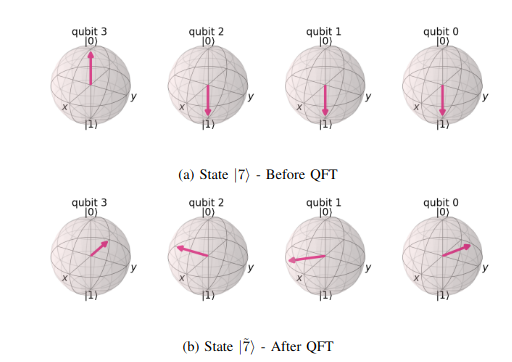





The code below serves as a playground for the QFT. Qiskit already comes with a QFT gate, which is handy.

Select the number of qubits and watch how the destination encoding sweeps the possible relative phases as the input passes through all basis states.

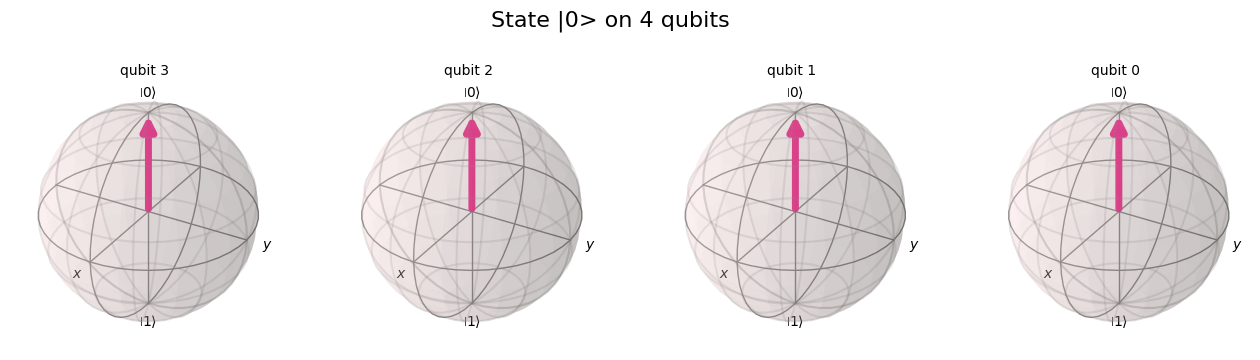

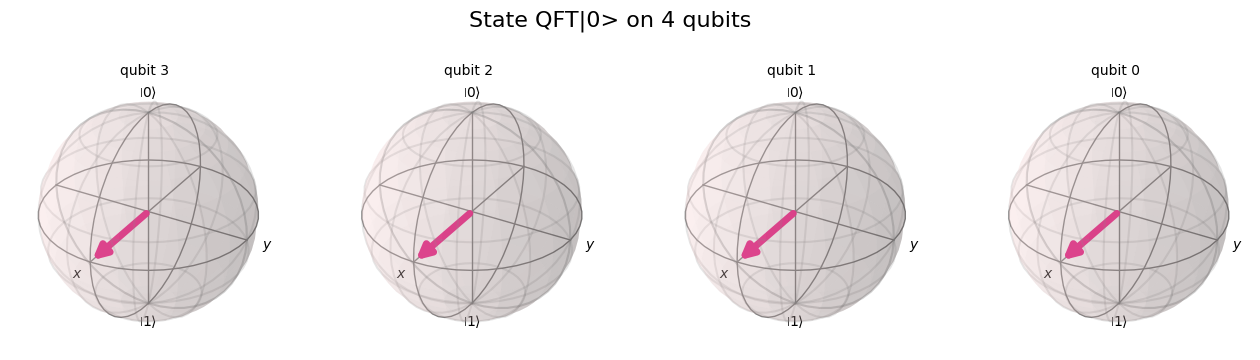

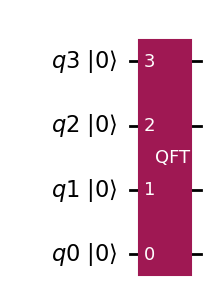

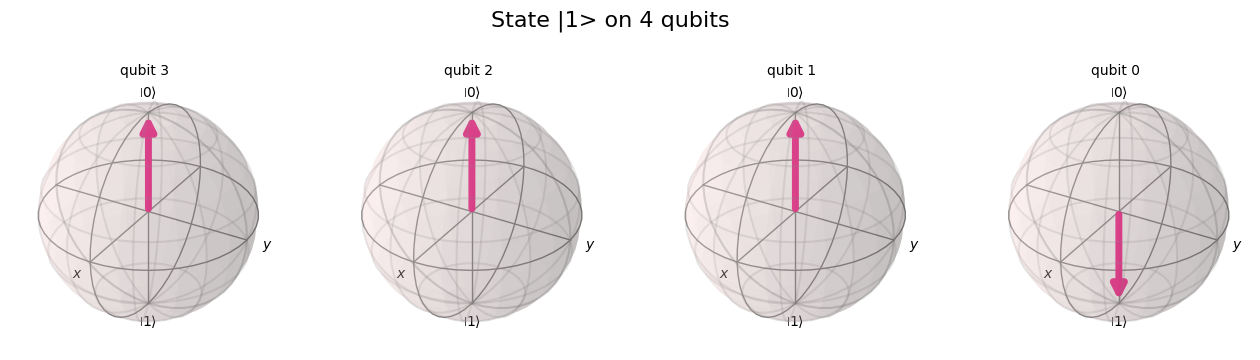

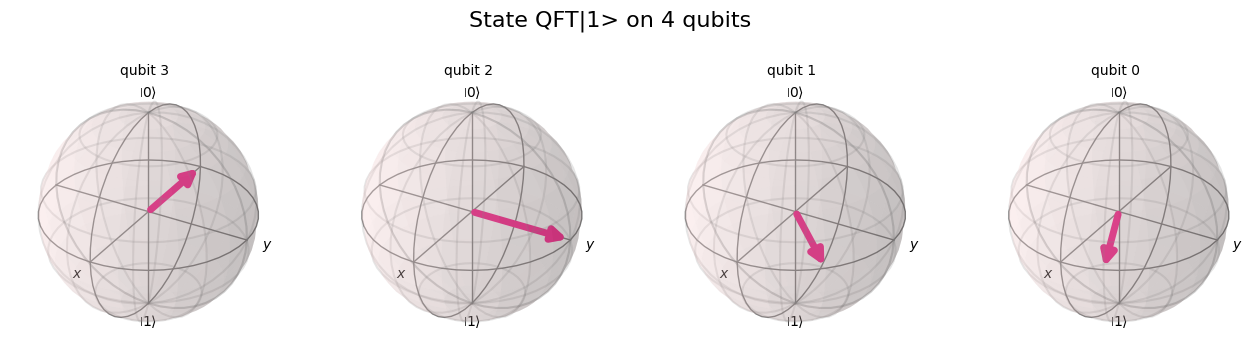

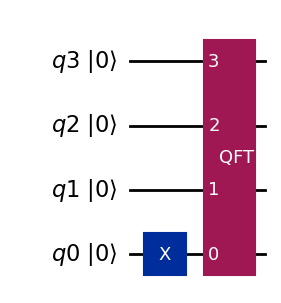

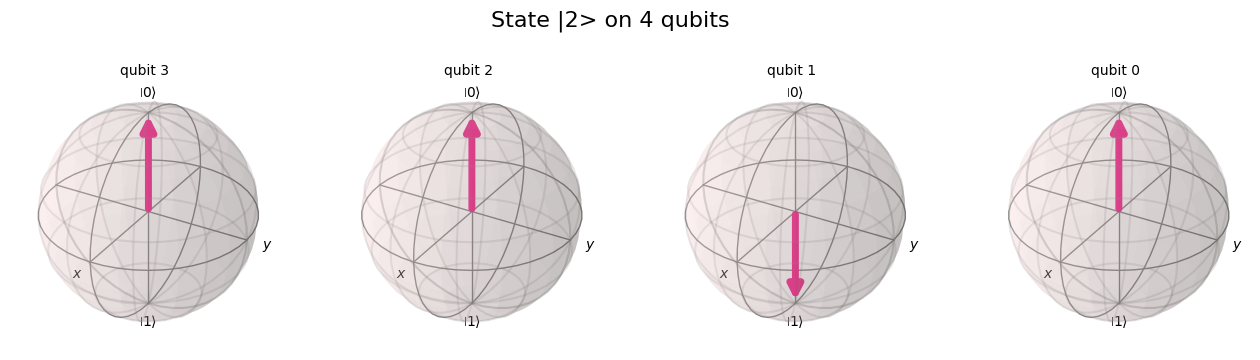

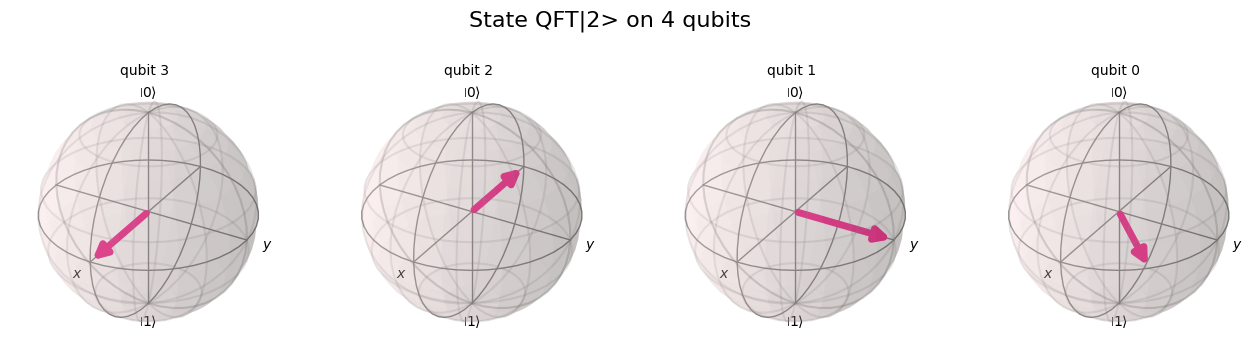

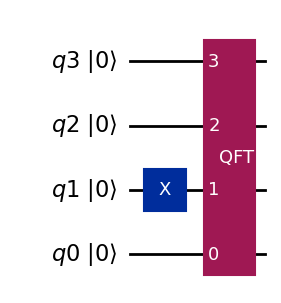

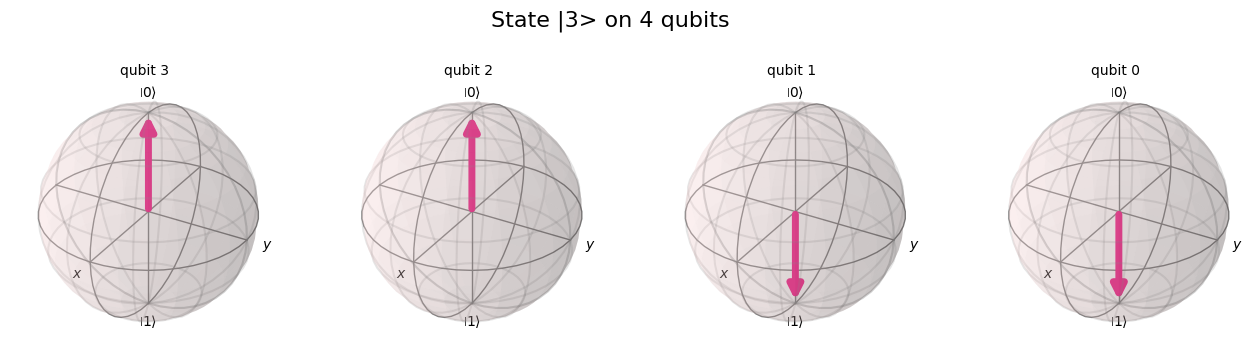

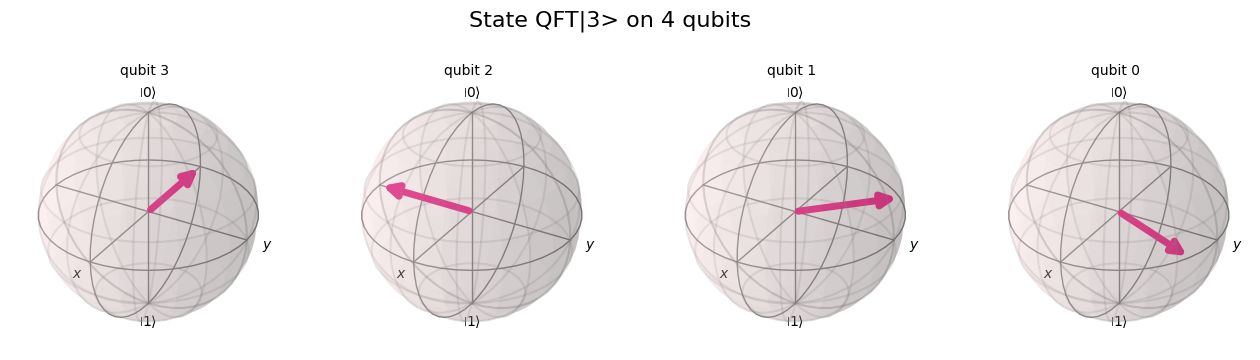

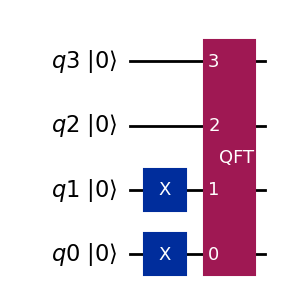

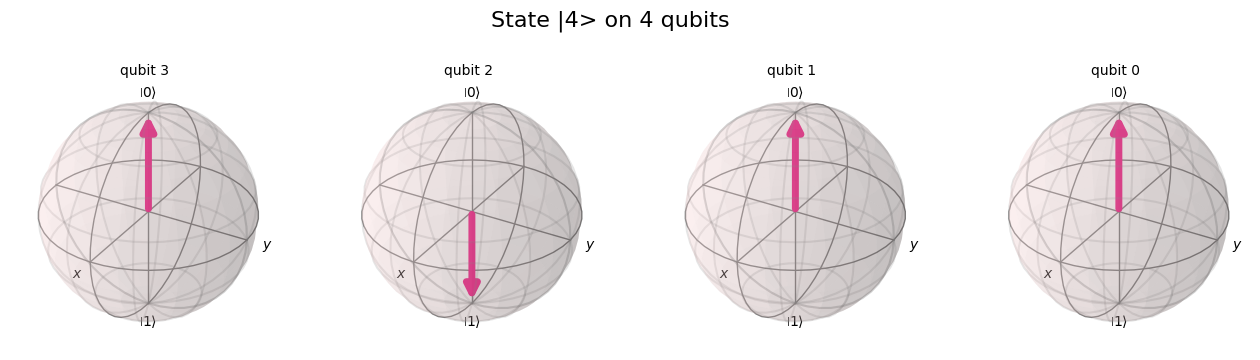

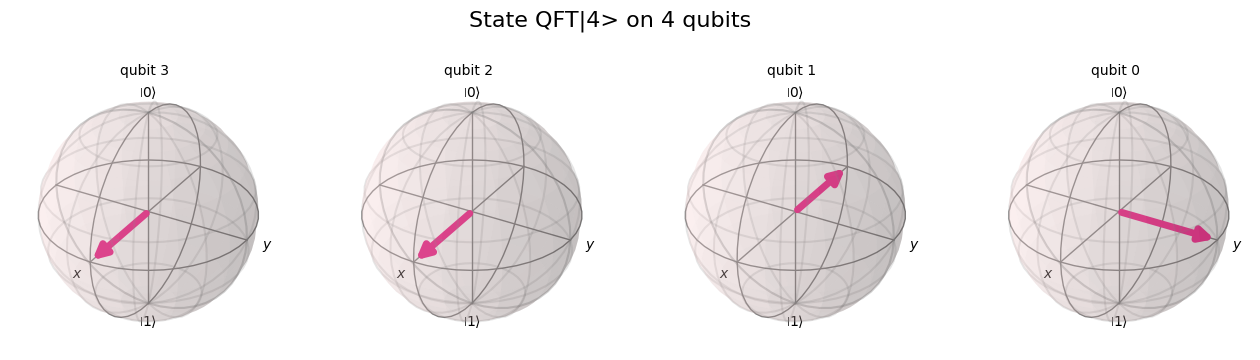

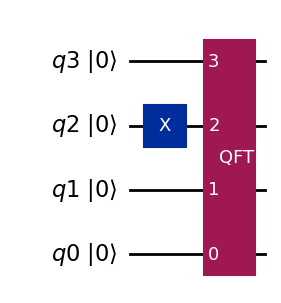

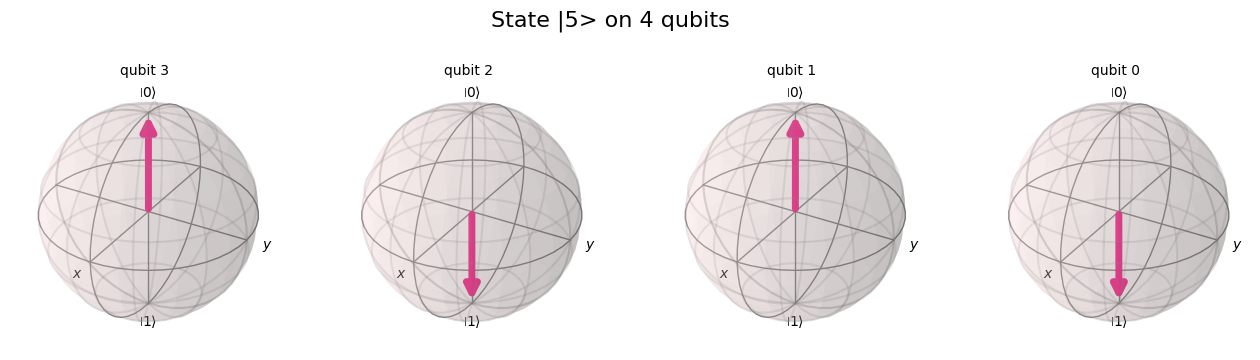

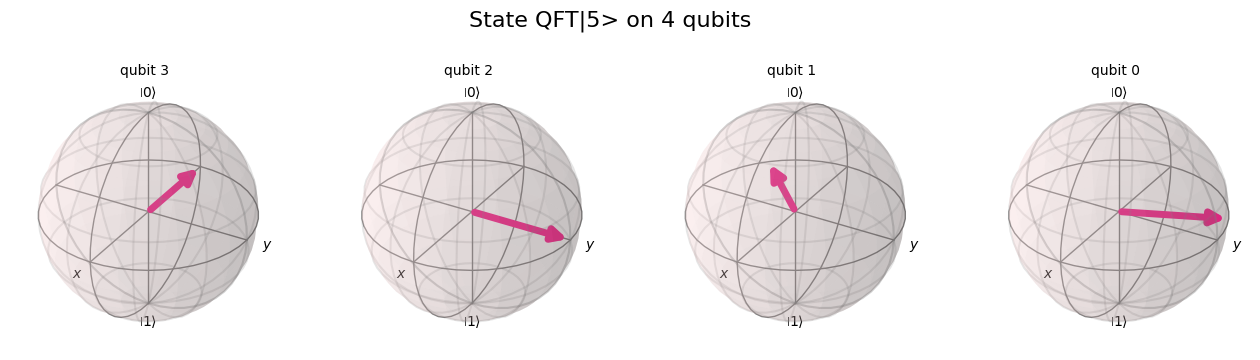

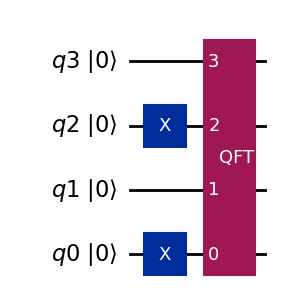

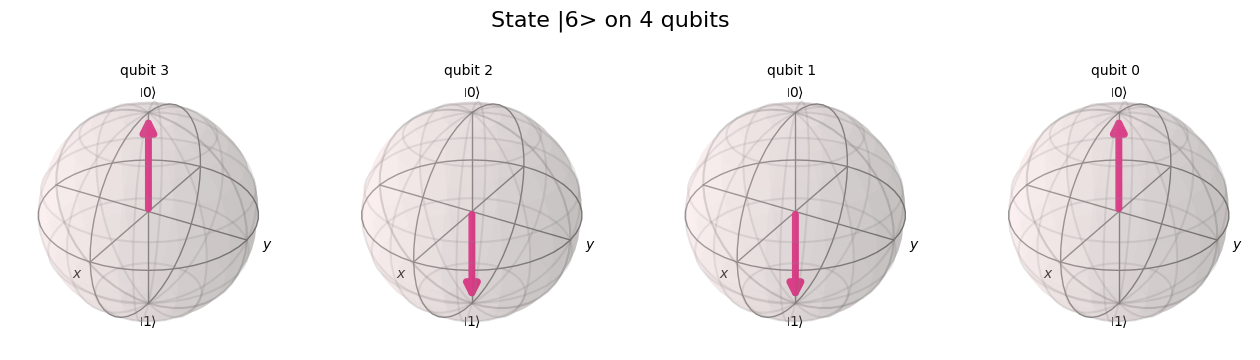

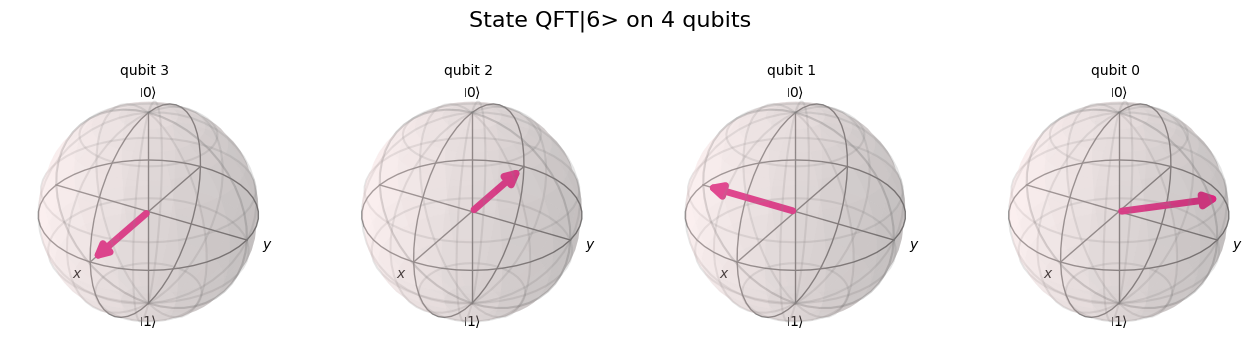

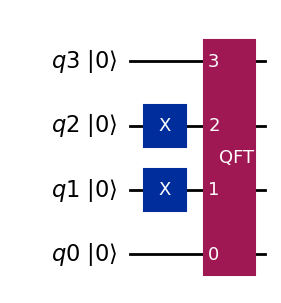

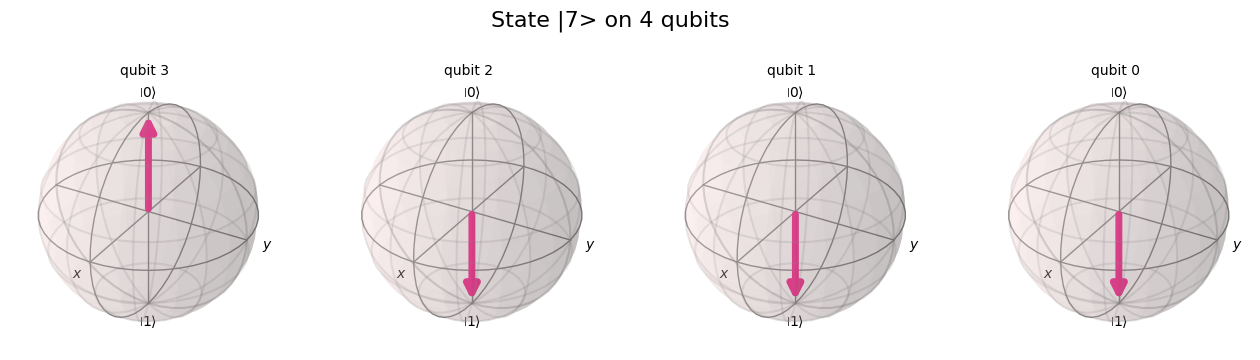

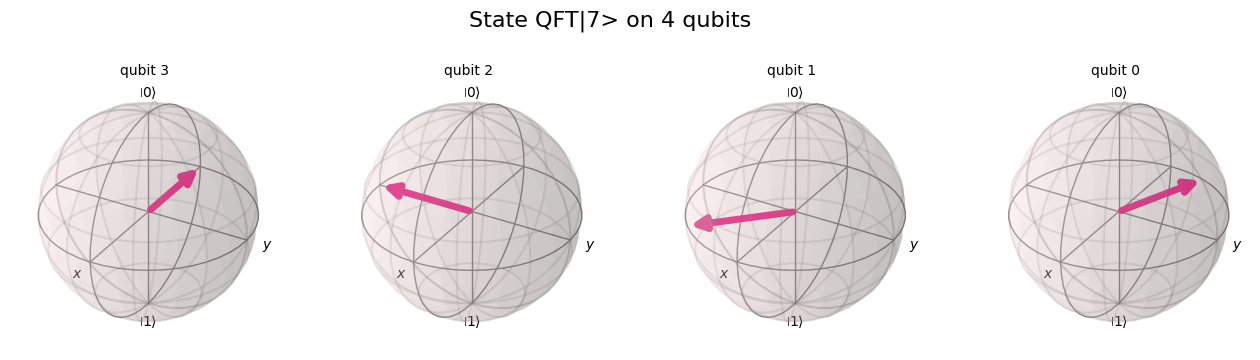

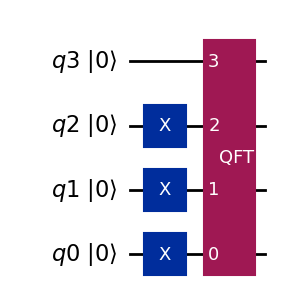

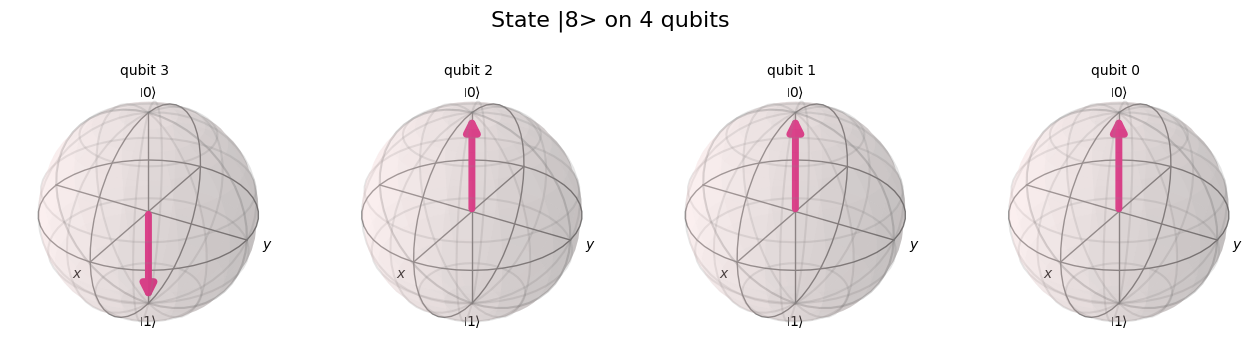

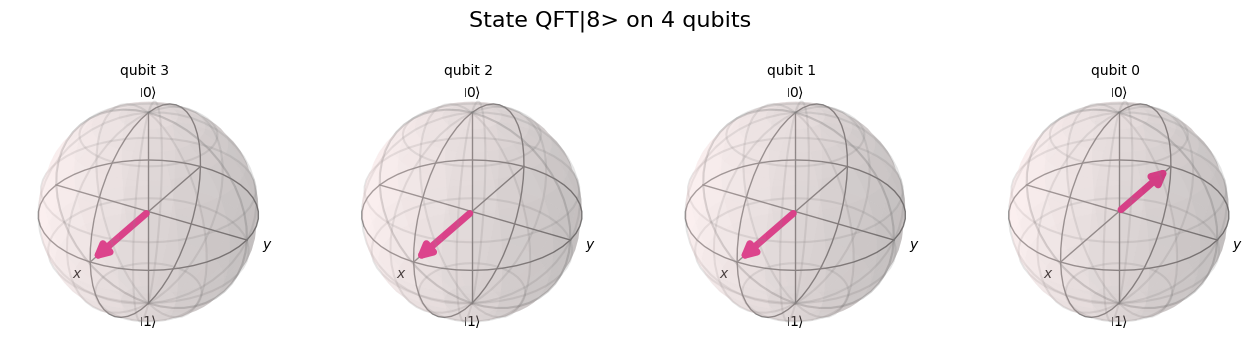

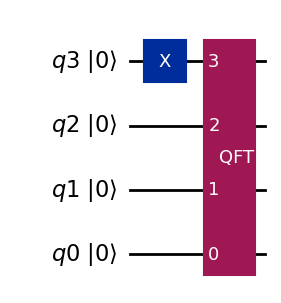

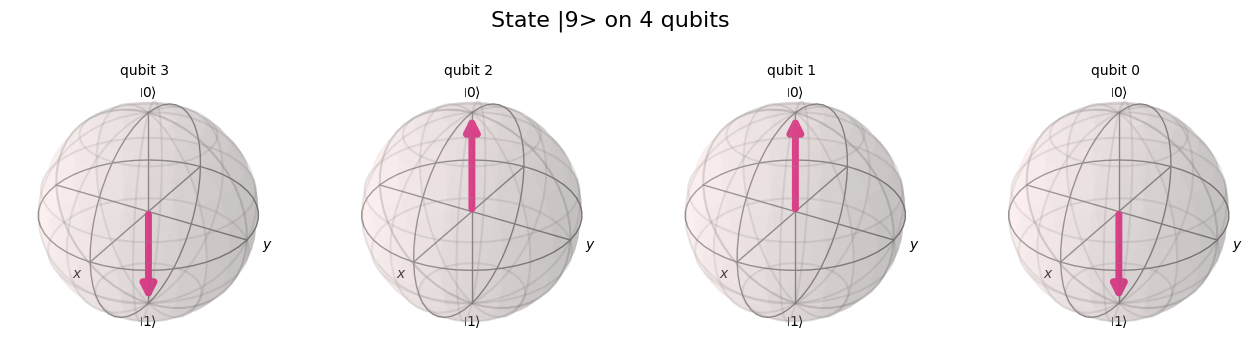

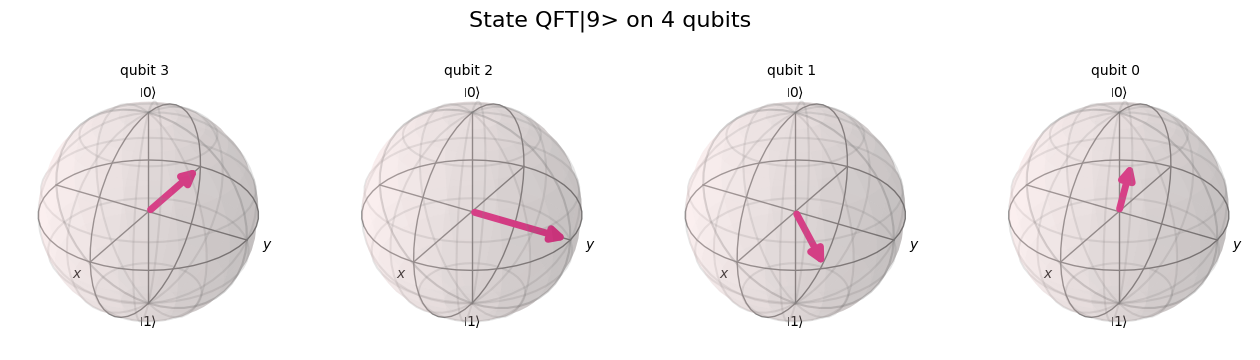

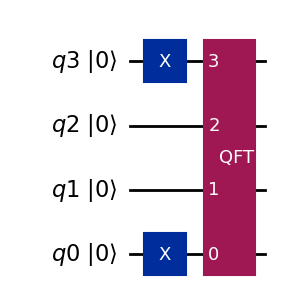

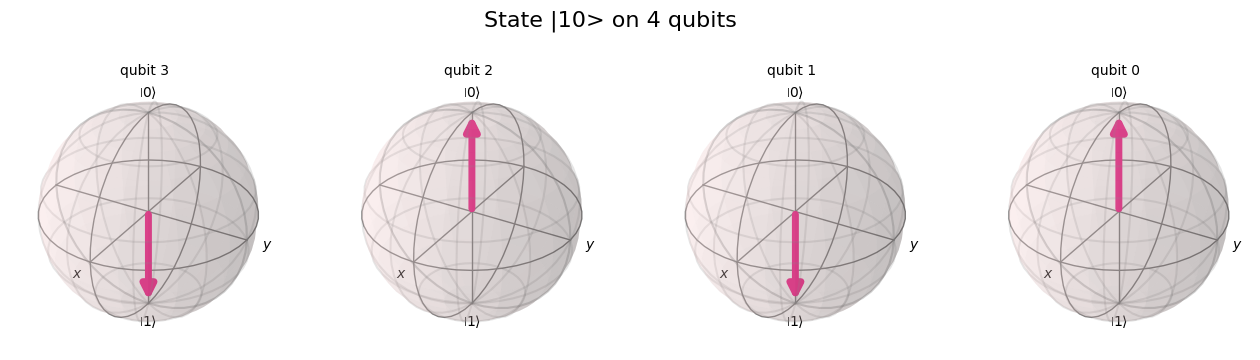

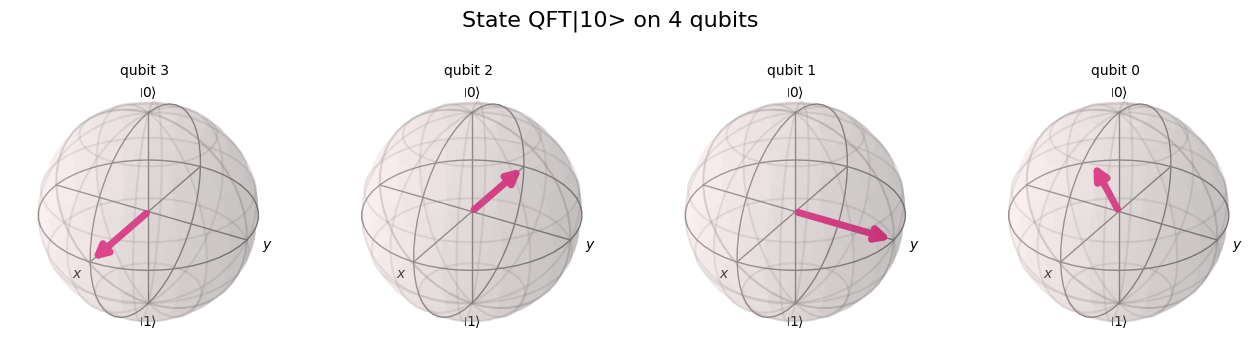

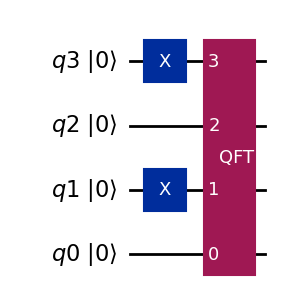

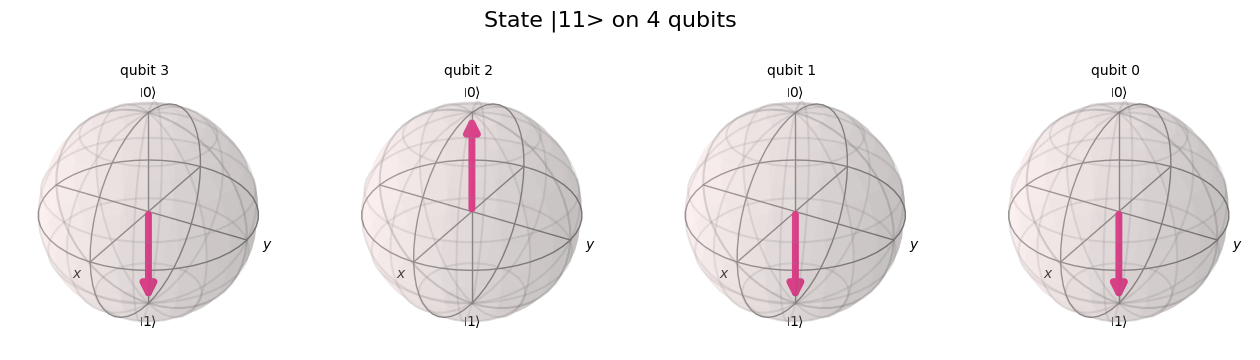

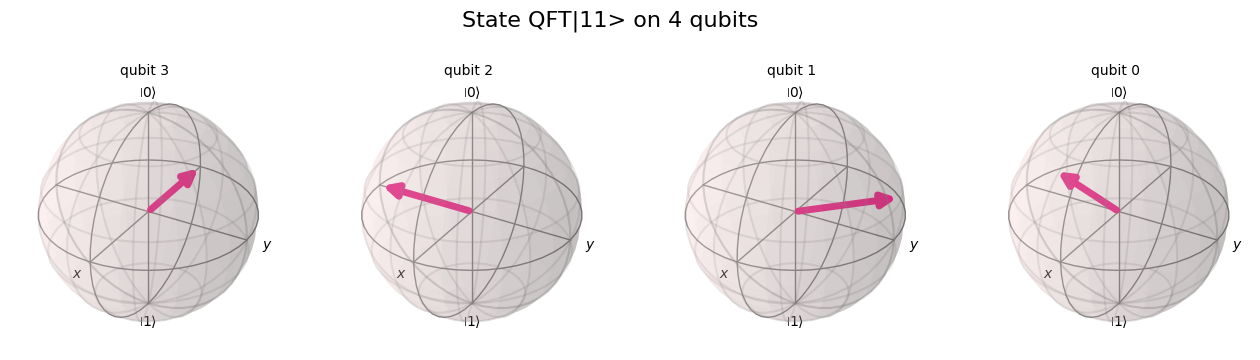

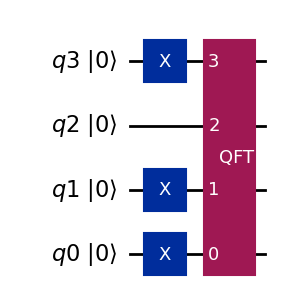

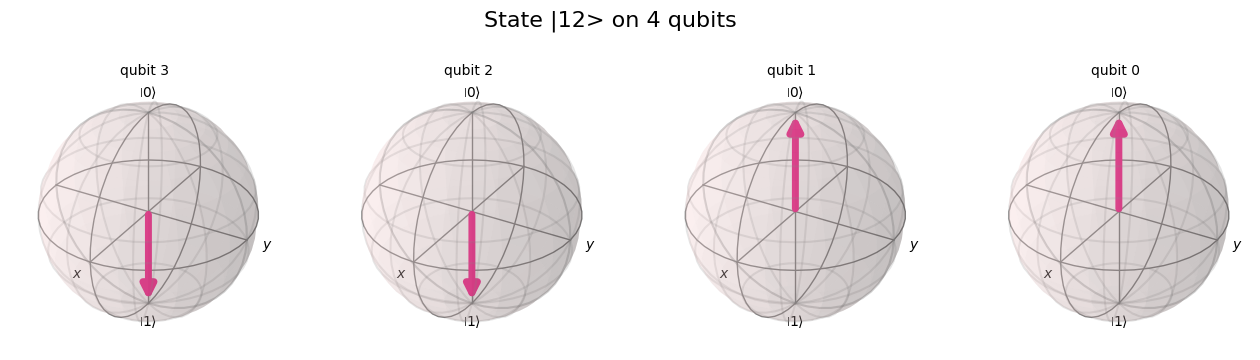

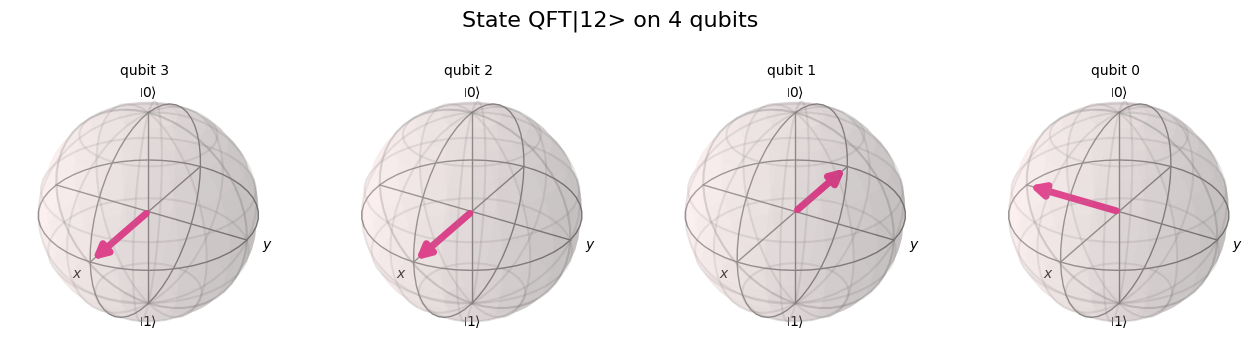

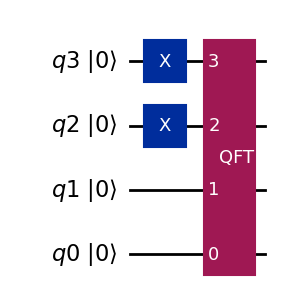

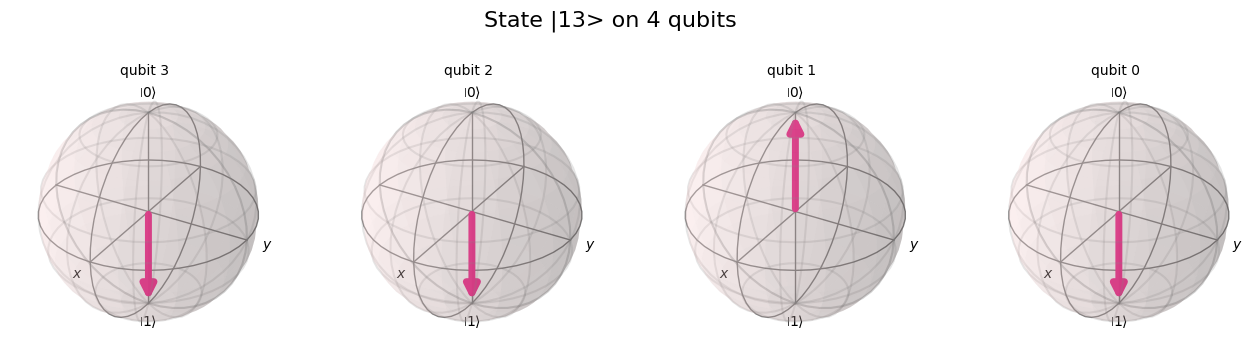

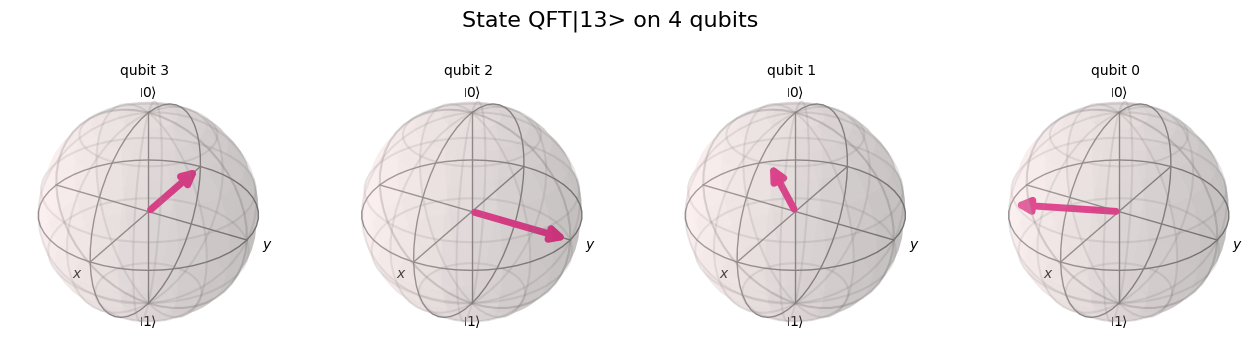

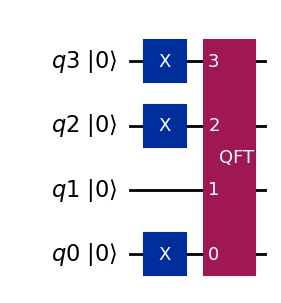

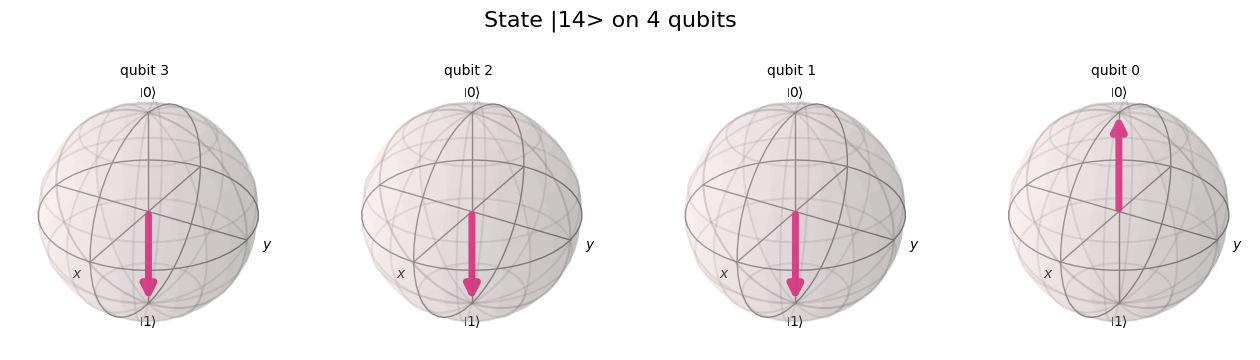

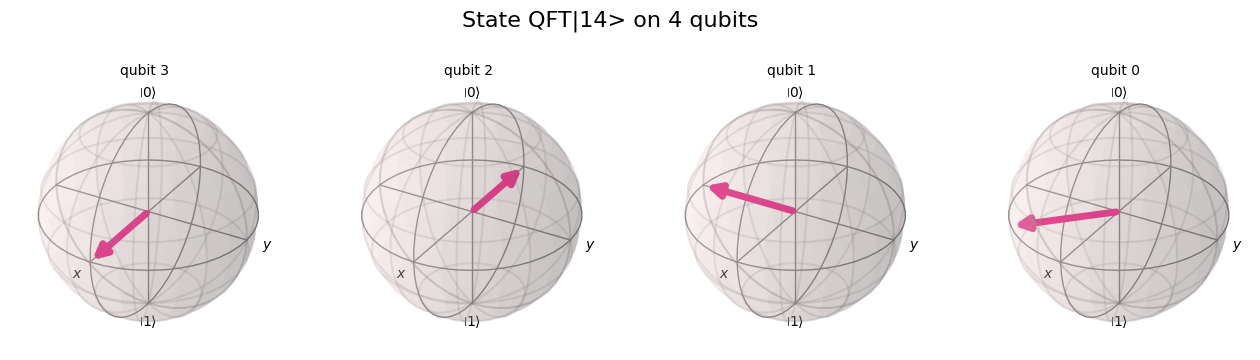

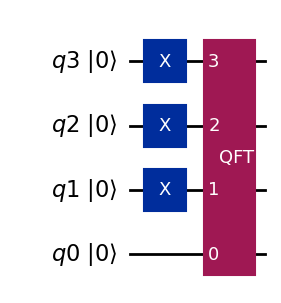

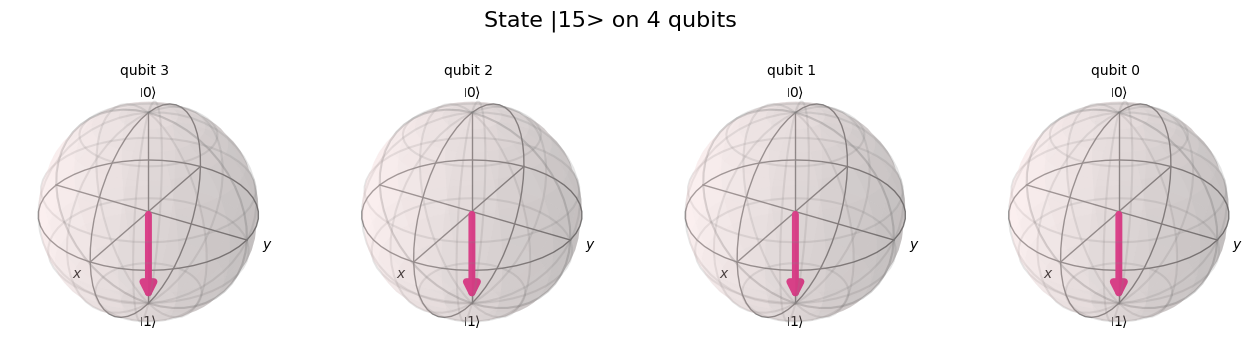

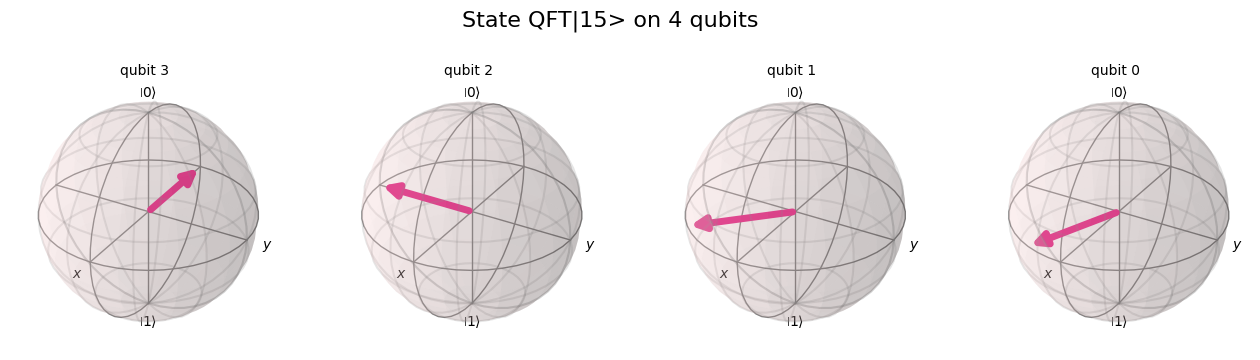

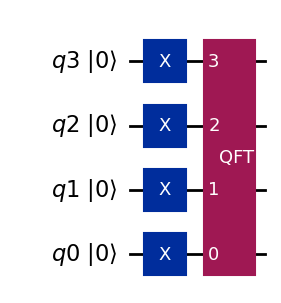

In [3]:
#########################################################################
##################### CHANGE HERE FOR DIFFERENT n #######################
#########################################################################
# Number of qbits in the system
n = 4
#########################################################################

# Create the quantum circuit with the number of specified qubits
q_register = []
for i in range(n):
    q_register.append(QuantumRegister(1, f'q{i}'))


# Sweep through all basis states
for j in range(pow(2, n)):
  # Reset the circuit
  qc = QuantumCircuit(*q_register)
  # For each application of QFT, we need to change the "input" state
  # This can be done by finding the binary representation of each number
  j_binary = bin(j)
  # Sweep in reverse to keep bit order
  temp = -1
  while j_binary[temp] != "b":
    # Values start on state 0, we bit flip what is one
    if j_binary[temp] == '1':
      qc.x(abs(temp)-1)
    temp -= 1

  # Input
  init_state = Statevector(qc)
  display(plot_bloch_multivector(init_state, title=f"State |{j}> on {n} qubits", reverse_bits=True))

  # Add a QFT to the circuit
  qfc = QFT(num_qubits=n, name='QFT')
  qc.append(qfc, list(range(n)))

  # Output
  final_state = Statevector(qc)
  display(plot_bloch_multivector(final_state, title=f"State QFT|{j}> on {n} qubits", reverse_bits=True))

  # Circuit for sanity/separation
  display(qc.draw('mpl', initial_state=True, reverse_bits=True))  # Reverse for visualization, highest is MSQ

## Quantum Phase Estimation (QPE)

Another key element of Shor's algorithm is the quantum phase estimation (QPE) circuit. Let $U$ be a quantum operator with some eigenstate $|\phi\rangle$ on n-qubits:

$$U|\phi\rangle = e^{2\pi i \theta} |\phi\rangle$$

Since $U$ is unitary, all its eigenvalues must be of module $1$, therefore allowing us to write the equation above, where $\theta$ is generally restricted to $\theta \in [0, 1)$ to avoid redundancy.

Any operator can be transformed into a controlled operator, and that is what will be done with $U$, resulting in operator $CU$. Consider the circuit in the figure, where the notation $CU^x$ means $x$ applications of gate $CU$.

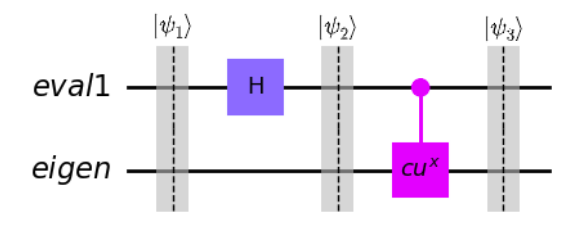

If we start the evaluation register (name will be clear in a second) at $|0\rangle$, we can compute the circuit analytically:

$$|\psi_1\rangle = |0\rangle|\phi\rangle$$

$$ |\psi_2\rangle = \frac{1}{\sqrt{2}}(|0\rangle|\phi\rangle + |1\rangle|\phi\rangle) $$

$$ |\psi_3\rangle = \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i x\theta} |1\rangle)|\phi\rangle $$

There are many interesting results here:

- Even though we generally say global phases are irrelevant, we have just encoded a global phase $e^{2\pi i \theta}$ of the eigenstate into a relative phase, which is relevant.
- We have also encoded the number of applied gates $x$ into the relative phase of a qubit.
- The qubit that encodes this information is the eval/control qubit. If we apply some sort of operation that extracts relative phases to the eval qubit, we can actually meeasure this value.

The points above hint towards QFT. Indeed, a reverse QFT (which must exist!) transforms relative phase encodings into basis states, which can be measured. But we need to make this process more palatable to the QFT. Consider the figure below, which accounts for succesive operations of the $CU^x$ gate, where the value of $x$ for evaluation qubit $q_n$ is $x = 2^n$:

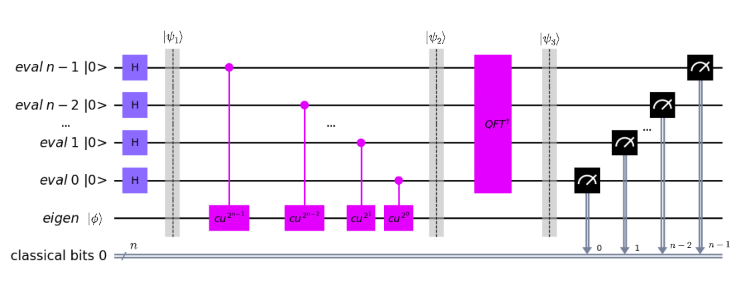

Again computing analytically for an interesting result:


$$ |\psi_1\rangle = \frac{1}{\sqrt{2^n}}(|0\rangle + |1\rangle)^{\otimes n} |\phi\rangle $$

$$ |\psi_2\rangle = \frac{1}{\sqrt{2^n}}\left(\bigotimes_{p=n-1}^{0}(|0\rangle + e^{2\pi i \; 2^p\theta} |1\rangle)\right)|\phi\rangle $$

$$ = \frac{1}{\sqrt{2^n}}\left(\bigotimes_{p=n-1}^{0}(|0\rangle + e^{\frac{2\pi i}{2^n} \; 2^n2^p\theta} |1\rangle)\right)|\phi\rangle $$

$$ = \left(\frac{1}{\sqrt{N}}\bigotimes_{p=n-1}^{0}(|0\rangle + \omega_N^{(2^n\theta) \; 2^p} |1\rangle)\right)|\phi\rangle →$$

$$ |\psi_2\rangle = QFT(|2^n\theta\rangle)|\phi\rangle $$

$$ |\psi_3\rangle = QFT^\dagger QFT(|2^n\theta\rangle)|\phi\rangle = |2^n\theta\rangle |\phi\rangle $$

Now, there was some "cheating" here. The last step in the derivation of $|\psi_2⟩$ is only valid if:

1) We assume that $2^n \theta \in \mathbb{Z_+}$

2) We need $0 \leq \theta \leq 1 - 2^{-n}$ so that $2^n \theta$ can be an element of the computational basis for $n$ qubits.

Concerning 1), we are going to relax that assumption in a few moments. As for 2), it shows us that increasing the number of qubits increases the number of $\theta$ that can be measured. By construction, the only unknown is $\theta$, so that is what we need to measure.

And why any of this matters? Why is QPE relevant for Shor? The value lies in the operator $U$, which was never defined. If you can make your operation (which could be, for example, something relating to primes...) into an operator $U$, it is possible to gain good information by measuring an eigenvalue of $U$.

For example, consider the Pauli gate $Y$. As we can infer from the Bloch sphere, $|+i⟩$ is an eigenstate:

$$Y|+i⟩ = e^{2\pi i \; \frac{1}{4}} |+i⟩$$

If you apply QPE on $Y,|+i⟩$ with 2 qubits, $2^n \theta = 1$ is an integer and a member of the computational basis. Therefore, the QPE circuit should work exactly, and it does, as shown in the figure below.

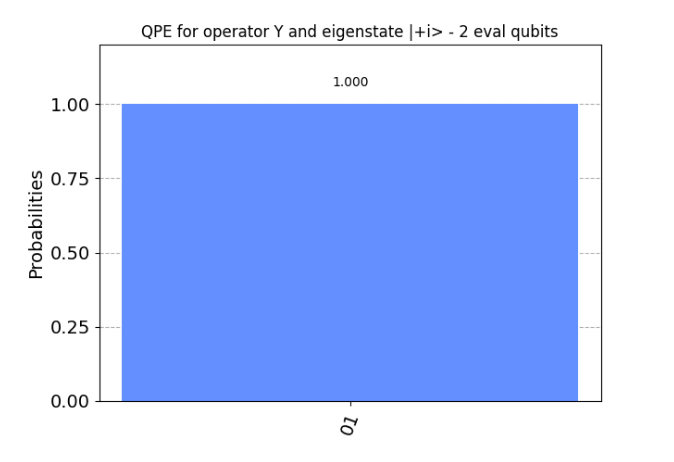

If assumption 1) is relaxed, QPE still works, but in a probabilistic bound. This result is beyond the scope of this document, but using an evaluation register with $n$ qubits, in order to obtain $\theta$ accurate to $p$ bits with probability $1-\epsilon$, we must have $n = p + \left\lceil \log_2\left(2 + \frac{1}{2\epsilon} \right) \right\rceil$. This also confirms the other way around: if you want better results, you need more qubits.

The code below implements QPE. You, the user, can change the operator $U$, the eigenstate $|\phi⟩$ and the number $n$ of eval qubits. Play around a bit with some known operators and eigenstates (maybe Pauli gates. Maybe some other gates) and see how the results of the measurement change. Remember to calculate $\theta$ to estimate what value the circuit is giving you.

Number of eigenstate qubits needed   : 1


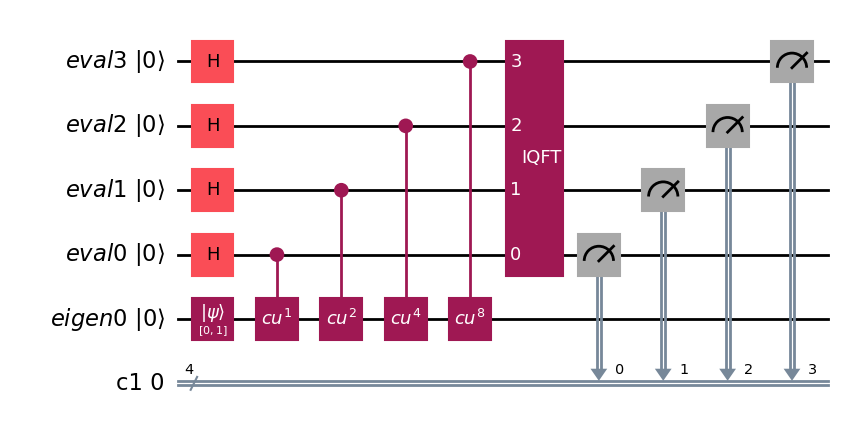

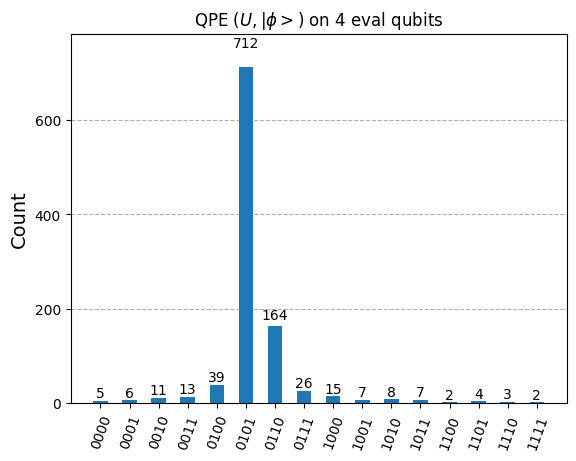

In [5]:
#########################################################################
############# CHANGE HERE FOR DIFFERENT U, |phi> and n ##################
#########################################################################
# Evaluation qubits register
n_eval = 4

# Suggested examples
# Y gate with eigstate |+i>:
# U = np.array([[0, 1], [-1, 0]]) phi = (1/np.sqrt(2))*np.array([1, 1j]) -> theta = 1/4 (exact measurement)

# Phase shift gate with eigstate |1>:
# U = np.array([[1, 0], [0, np.exp(1j*2*np.pi/3)]]) phi = np.array([0, 1]) -> theta = 1/3 (probabilistic measurement)

# CNOT gate with eigstate |00>
# U = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]) phi = np.array([1, 0, 0, 0]) -> theta = 0 (exact measurement)

U = np.array([[1, 0], [0, np.exp(1j*2*np.pi/3)]])
phi = np.array([0, 1])
#########################################################################


# Qubits in eigenstate register
n_eigen = int(np.log2(phi.size))
print(f"Number of eigenstate qubits needed   : {n_eigen}")

# Build circuit structure
eigen_register = []
for i in range(n_eigen):
    eigen_register.append(QuantumRegister(1, f"eigen{i}"))
eval_register = []
for i in range(n_eval):
    eval_register.append(QuantumRegister(1, f"eval{i}"))
qc = QuantumCircuit(*eigen_register, *eval_register, ClassicalRegister(n_eval))

# Initialize eigenstate
init_gate = Initialize(Statevector(phi))
qc.append(init_gate, list(range(n_eigen)))

# Initialize hadamards on eval qubits
for i in range(n_eval):
  qc.h(i + n_eigen)

# Add CU^(2^x) gates
for i in range(n_eval):
    power = pow(2, i)
    compound_u = np.linalg.matrix_power(U, power)
    compound_u_gate = UnitaryGate(compound_u)
    compound_u_gate.name = f"$CU^{2**i}$"
    controlled_u_gate = compound_u_gate.control()
    qc.append(controlled_u_gate, [i+n_eigen, *list(range(n_eigen))])

# Inverse qft
qft = QFT(num_qubits=n_eval)
qft_inverse = qft.inverse()
qc.append(qft_inverse, [i+n_eigen for i in range(n_eval)])

# Assign measurements
for i in range(n_eval):
    qc.measure(i+n_eigen, i)

# Draw circuit
display(qc.draw('mpl', initial_state=True, reverse_bits=True))  # Reverse for visualization, highest is MSQ

# Simulate the circuit
simulator = AerSimulator()
qct = transpile(qc, simulator) # Without this, the simulator can't execute the circuit
result = simulator.run(qct, shots=1024).result()

data = result.get_counts(qct)
display(plot_histogram(data, title=f"QPE $(U, |\phi>)$ on {n_eval} eval qubits"))

## Shor's Algorithm: Order Finding

Shor's algorithm is essentially an order finding algorithm. Recall the definition of the order of an element: the order of an element $a$ in multiplicative group $(\mathbb{G}, \cdot)$ is the smallest positive integer $n$ such that $a^n = 1_G$. Taking the modular-arithmetic group $(\mathbb{Z}_N, \otimes)$ the order $r$ of element $a \in \mathbb{Z}_N$ such that $\gcd(a, N) = 1$ is the smallest positive integer value that satisfies $a^r \mod{N} = 1$. The problem of finding $r$ is considered hard if $N$ is sufficiently large.

We can resort to an "abuse of notation" to convert this idea of modulo exponent to a quantum operator:

$$u(x) = a^x \mod{N} → U|j⟩ = |aj \mod{N}⟩$$

If $|j\rangle$ is always an element of the computational basis, this operation is sensical because we can simply operate on the "decimal" $j$. Furthermore, if we have enough qubits $n$ such that $2^n \geq N$, the value of $U|j\rangle$ will also be a member of the computational basis.

In a very *ad hoc* fashion, consider the state $|u_s⟩, s \in \mathbb{Z}$, created by a superposition of some basis elements over an $r$-period:

$$
|u_s\rangle = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{-2\pi i \frac{sk}{r}}|a^k \mod{N}\rangle
$$

Two results are important here.

- $|u_s\rangle$ is an eigenstate of $U$, with eigenvalue $e^{2\pi i \frac{s}{r}}$:

$$U|u_s\rangle = U \left( \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{-2\pi i \frac{sk}{r}}|a^k \mod{N}\rangle \right)$$

$$=\frac{1}{\sqrt{r}}\sum_{k=0}^{r-1}e^{-2\pi i \frac{sk}{r}} |a^{k+1} \mod{N}\rangle$$

$$=e^{2\pi i \frac{s}{r}}\left(\frac{1}{\sqrt{r}}\sum_{k'=1}^{r}e^{-2\pi i \frac{sk'}{r}} |a^{k'} \mod{N}\rangle \right)$$

$$= e^{2\pi i \frac{s}{r}} |u_s\rangle $$

- The values of $|u_s\rangle$ are orthonormal:

$$\langle u_p | u_s \rangle = \frac{1}{r} \sum_{k_1=0}^{r-1}\sum_{k_2=0}^{r-1}e^{2\pi i \frac{(pk_1-sk_2)}{r}}\langle a^{k_1} \; mod{N}|a^{k_2} \; mod{N}\rangle$$

$$=\frac{1}{r} \sum_{k=0}^{r-1} e^{2\pi i k \frac{(p-s)}{r}}$$

$$= \delta_{ps}$$

These results mean that the values of $|u_s\rangle$, plus the rest of the computational basis of the $n$ qubits, form a basis with can be properly superposed.

Since the values of $s$ are not known beforehand, however, we can't just feed $|u_s\rangle$ into a QPE circuit to find $r$. But a very interesting result happens if we sum $|u_s\rangle$ over a period:

$$ |\phi\rangle = \frac{1}{\sqrt{r}}\sum_{s=0}^{r-1}|u_s\rangle $$

$$=\frac{1}{r}\sum_{k=0}^{r-1}\left(\sum_{s=0}^{r-1}e^{-2\pi i \frac{sk}{r}} \right) |a^k \mod{N}\rangle$$

$$=\frac{1}{r}\sum_{k=0}^{r-1} r\delta_{0k}|a^k \mod{N}\rangle$$

$$ = |a^0 \mod{N}\rangle $$

$$ = |1⟩$$

This means that a uniform superposition of the $|u_s⟩$ elements is equal to the $|1⟩$ state, which is trivially obtained by a bit-flip on the LSB of the eigenstate register.

Now we can use QPE to make things interesting: consider a circuit such as the one below.

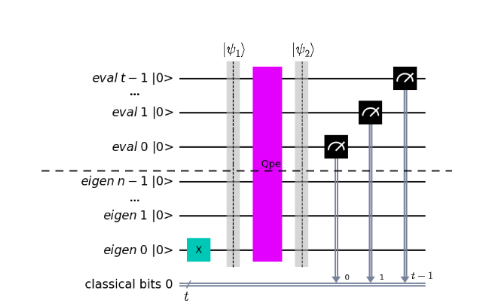

We can calculate the states at each point of the circuit:

$$|\psi_1\rangle = |0\rangle^{\otimes t} |1\rangle_n $$

$$ = \frac{1}{\sqrt{r}}\left(\sum_{s=0}^{r-1}|0\rangle^{\otimes t}|u_s\rangle_n\right) $$

$$ |\psi_2\rangle = \frac{1}{\sqrt{r}}\left(\sum_{s=0}^{r-1}QPE(|0\rangle^{\otimes t}|u_s\rangle_n)\right) $$

$$ = \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1}|2^t \frac{s}{r}\rangle_t |u_s\rangle_n $$

By performing a measurement on the $t$ evaluation registers, we can find the value of order $r$. In the case where $\frac{2^t}{r} \in \mathbb{Z}$, all elements $|s \frac{2^t}{r}\rangle$ are in the computational basis of the evaluation register, thus only these states will be measured, in very marked fashion. On the other hand, similarly to what happens with the QPE algorithm, when $\frac{2^t}{r} \notin \mathbb{Z}$ measurements will be distributed in a more "noisy" fashion, with peaks in basis elements which are the closest to $s \frac{2^t}{r}$.


We can see this behavior in the example of the figure below, where $N=13$ and $a = \{5, 6\}$, which have orders $4$ and $12$ respectively. As expected, the case where $a=5, r = 4$ yields measurements precisely on $\{0,64,128,192\}$. When $a=6, r=12$, however, measurements will be dispersed, but with higher counts on integers closest to $\{0, 21.\bar{3}, 42.\bar{6}, ...\}$.

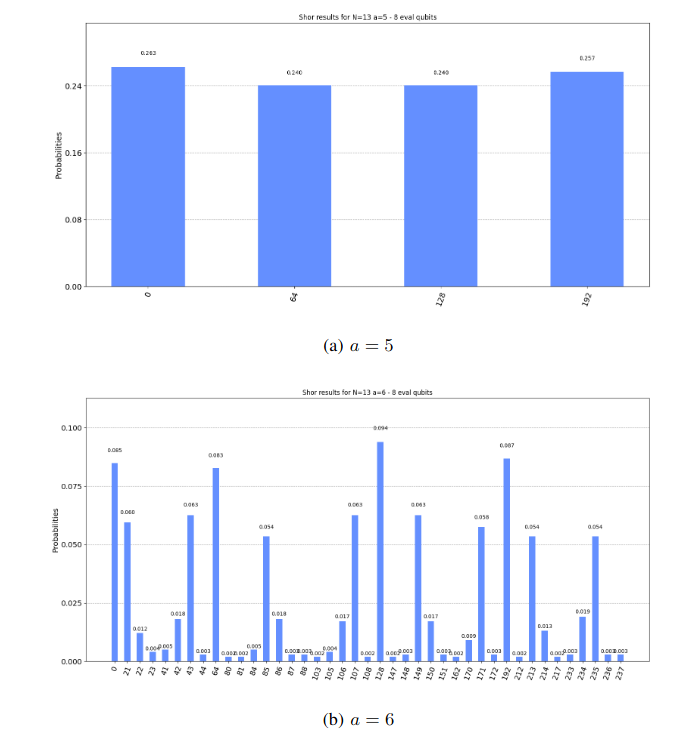

Even when the measurements are not in exact multiples, such as in the bottom previous figure, it is still possible to estimate the order $r$ of $a$ by using continued fraction expansions (CFE). By limiting the $t$ evaluation qubits to $N^2 \leq 2^t < 2N^2$, there is only one fraction with denominator $N$ that is within $\frac{1}{N^2}$ of $\frac{v}{2^t}$, where $v$ is an output measurement of the algorithm. When $r$ and $s$ are co-prime, the denominator of said fraction simplifies to $r$. In the example of the figure above, suppose the algorithm has yielded $v = 21$. The CFE outputs $\frac{1}{12}$, resulting in $r=12$, which is precisely the value desired. It can be quickly verified if the denominator outputted by the continued fraction expansion is in fact the order of $a$. Running Shor's algorithm multiple times increases the chance of correctly estimating $r$.


Use the code below to find the order of elements $a$ (mod $N$). Play around with values of $a$ and $N$ to see how Shor's algorithm behaves.

Eigenstate qubits: 4
Evaluation qubits: 8


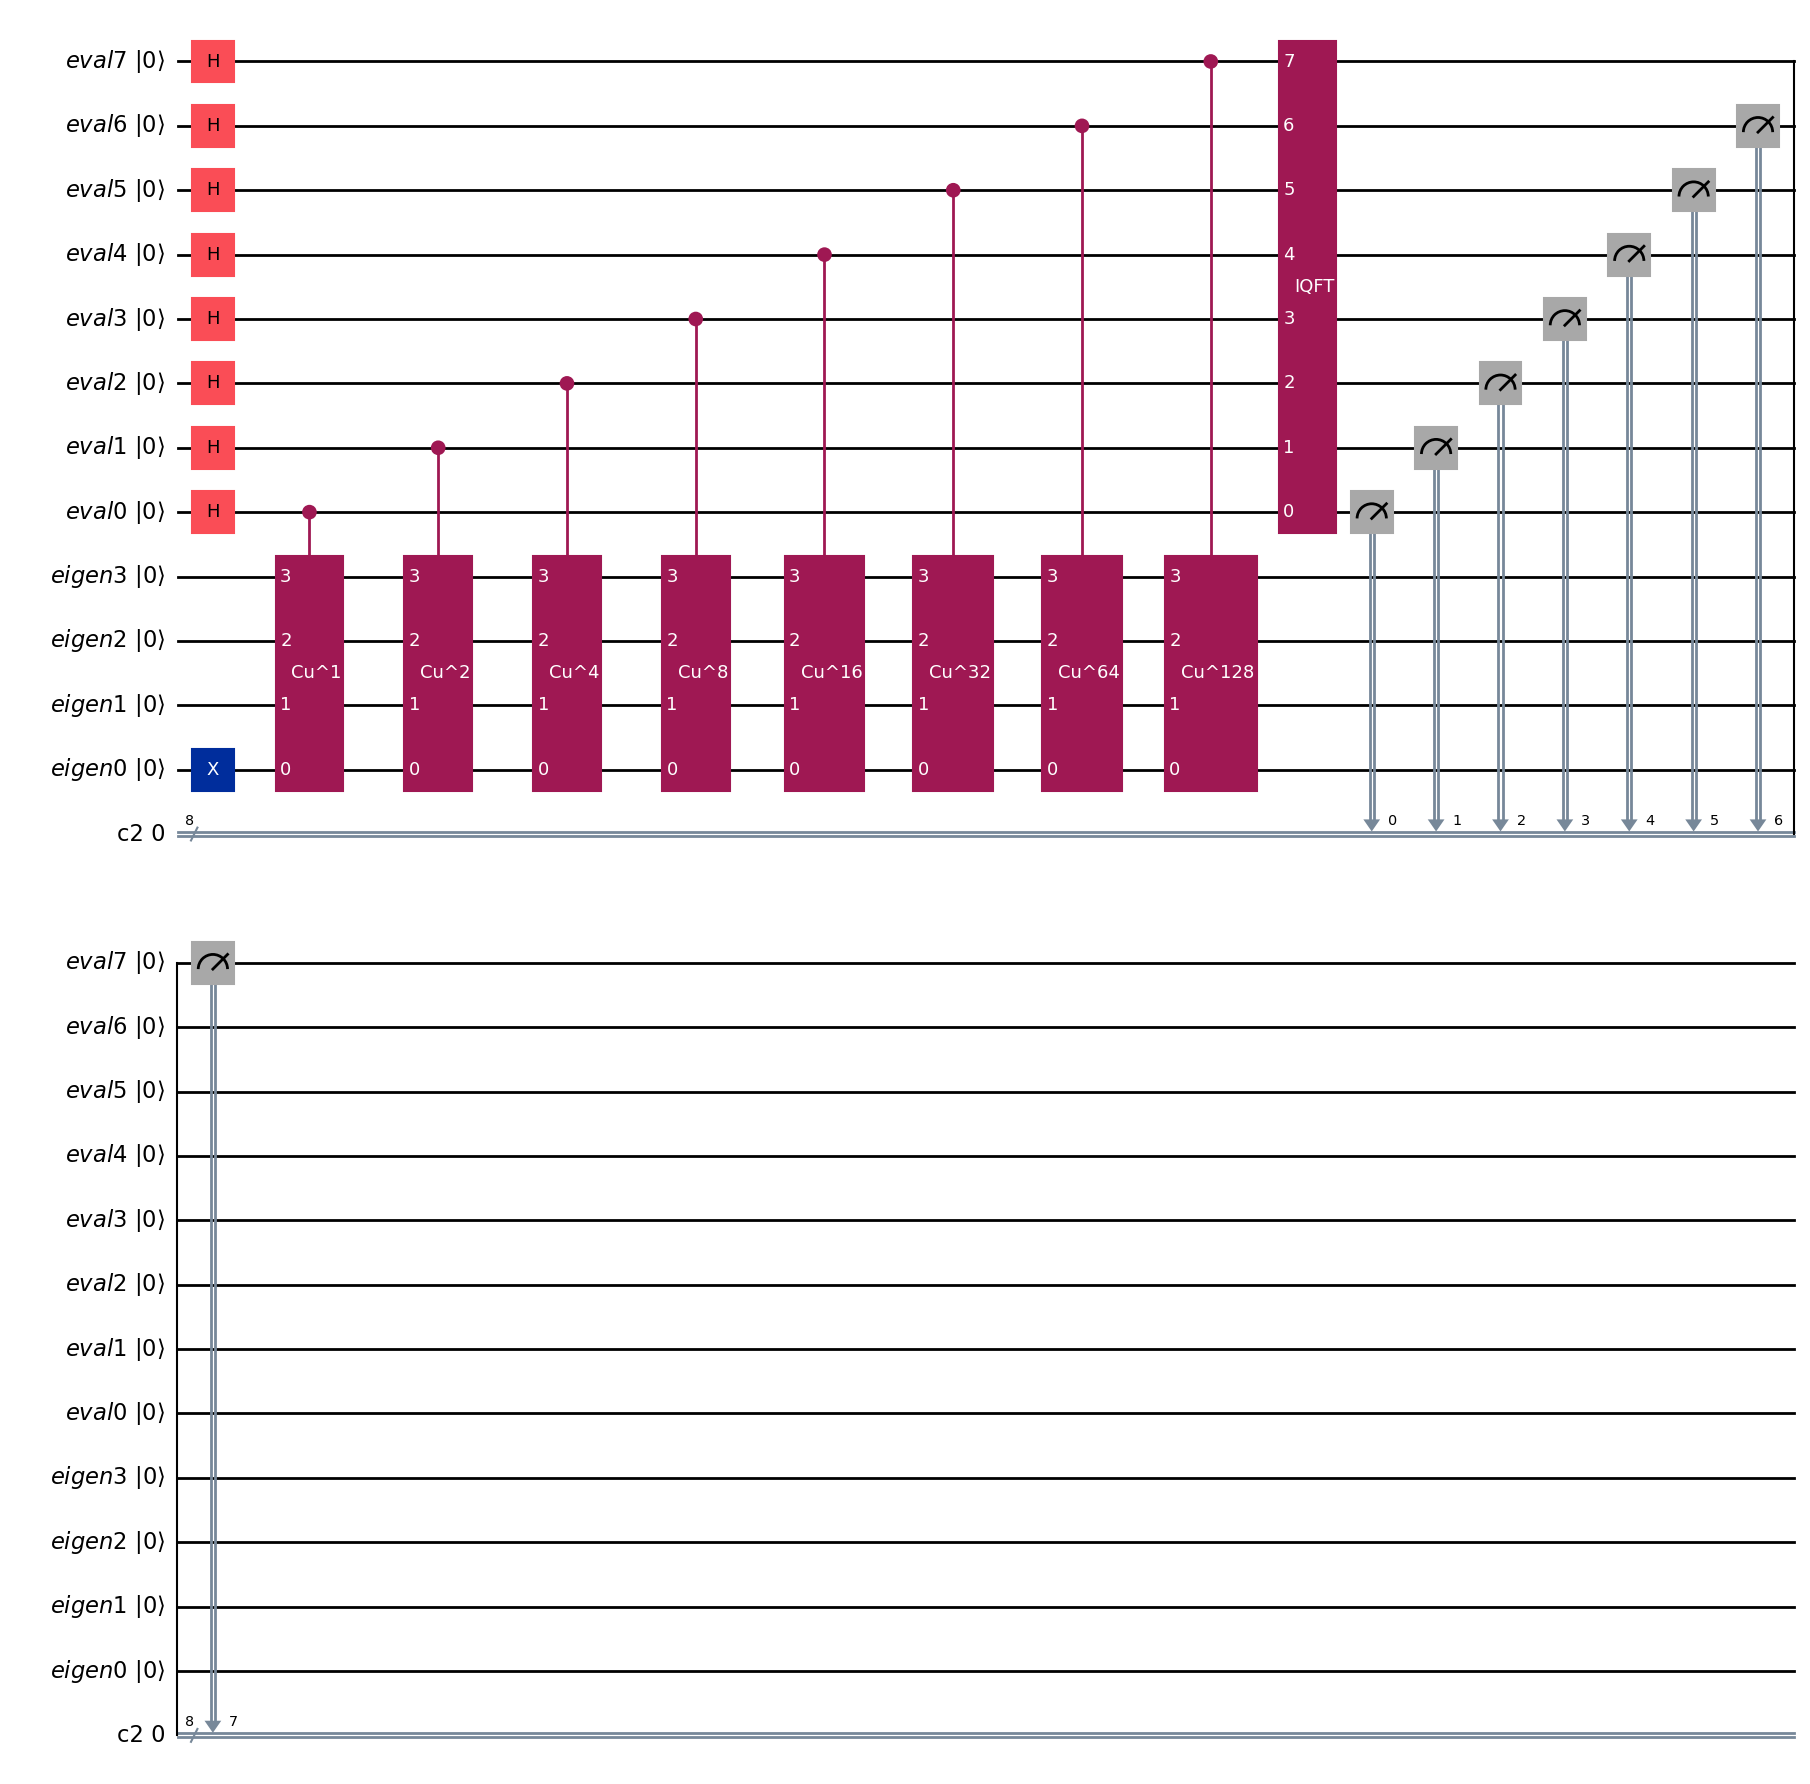

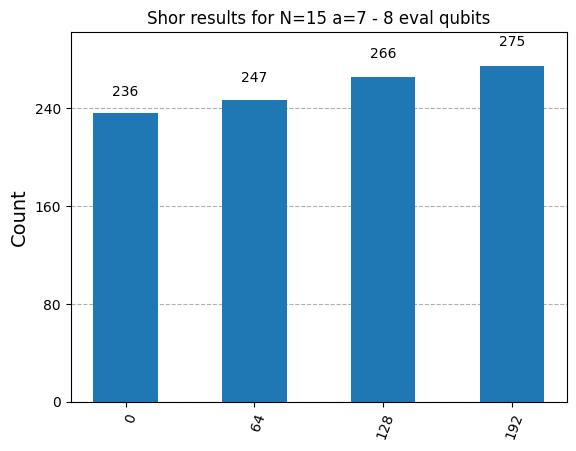

Order of element a=7 base N=15 is r=4


In [6]:
#########################################################################
################## CHANGE HERE FOR DIFFERENT a, N #######################
#########################################################################
N = 15
a = 7
#########################################################################

# Calculate size of the eigenstate register
eigen_qubits = math.ceil(np.log2(N))
# Calculate size of the evaluation register
eval_qubits = math.ceil(np.log2(pow(N, 2)))
print(f"Eigenstate qubits: {eigen_qubits}")
print(f"Evaluation qubits: {eval_qubits}")

 # Build circuit structure
eigen_register = []
for i in range(eigen_qubits):
    eigen_register.append(QuantumRegister(1, f"eigen{i}"))
eval_register = []
for i in range(eval_qubits):
    eval_register.append(QuantumRegister(1, f"eval{i}"))
qc = QuantumCircuit(*eigen_register, *eval_register, ClassicalRegister(eval_qubits))

# Circuit creation
# Start state |1> on eigenstate register to superpose |us>
qc.x(0)

# Start hadamards on evaluation register
# These will be part of the QPE circuit
for i in range(eval_qubits):
    qc.h(i + eigen_qubits)


# This creates operator U based on modular arithmetic
def generate_base_matrix(a, N, eigen_qubits):
    # Build the matrix, which must support 2**eigen_qubits elements
    u = np.zeros([2 ** eigen_qubits, 2 ** eigen_qubits], dtype=int)
    # Elements in 0 <= i <= N-1
    for i in range(N):
        u[a * i % N][i] = 1
    # For the rest, it is irrelevant. We'll not deal with these states
    for i in range(N, 2 ** eigen_qubits):
        u[i][i] = 1
    return u

# Build controlled U operators
u = generate_base_matrix(a, N, eigen_qubits)
for i in range(eval_qubits):
    power = pow(2, i)
    compound_u = np.linalg.matrix_power(u, power)
    compound_u_gate = UnitaryGate(compound_u)
    compound_u_gate.name = f"CU^{2 ** i}"
    controlled_u_gate = compound_u_gate.control()
    qc.append(controlled_u_gate, [i + eigen_qubits, *list(range(eigen_qubits))])

# Inverse qft
qft = QFT(num_qubits=eval_qubits)
qft_inverse = qft.inverse()
qc.append(qft_inverse, [i + eigen_qubits for i in range(eval_qubits)])

# Assign measurements
for i in range(eval_qubits):
    qc.measure(i + eigen_qubits, i)

# Draw
display(qc.draw('mpl', initial_state=True, reverse_bits=True))


# Simulate the circuit
simulator = AerSimulator()
qct = transpile(qc, simulator) # Without this, the simulator can't execute the circuit
result = simulator.run(qct, shots=1024).result()
data = result.get_counts(qct)
# Make data decimal for easier viewing
data_dec = dict()
for bin_key in data.keys():
    data_dec[int(bin_key, 2)] = data[bin_key]
display(plot_histogram(data_dec, title=f"Shor results for N={N} a={a} - {eval_qubits} eval qubits"))

# Order the values by largest measurement
sorted_measurements = [key for key, _ in sorted(data_dec.items(), key=lambda item: item[1], reverse=True)]

# Try multiple measurements to see if any work
found = False
i = 0
r = 0
while not found and i < len(sorted_measurements):
  v = sorted_measurements[i]
  frac = Fraction(v, 2**eval_qubits)
  test_order = frac.limit_denominator(max_denominator=N).denominator
  if pow(a, test_order, N) == 1:
    found = True
    r = test_order
  else:
    i += 1

if found:
  print(f"Order of element a={a} base N={N} is r={r}")
else:
  print(f"Order not found :-(. Try running again")

## Shor and RSA

To break RSA, we are given a big semi-prime $N$ that we want to decompose. By picking a random $a < N$, we can run Shor's algorithm to find the order $r$ of $a$. If $r$ is even, we can decompose the equation below:

$$a^r \equiv 1 \pmod{N} \rightarrow (a^{\frac{r}{2}}+1)\times(a^{\frac{r}{2}}-1) = k \times N$$

If neither term on the left-hand side of the equation above is a multiple of $N$, both terms share nontrivial factors with $N$. Upon obtaining $p$ and $q$ from the algorithm, it can be quickly verified if $N \mod{p}= 0$ and $N \mod{q} = 0$. If not, we can run the algorithm as many times as are needed.

If $r$ is odd, just pick a different $a$ and run the process again.

Try the code below in conjuntion with the code for Shor's algorithm to factor some RSA numbers.

In [7]:
## REMEMBER TO RUN THE PREVIOUS CELL BEFORE RUNNING THIS ONE ##
print(f"From the previous cell, we found that element a={a} has order r={r} mod N={N}")

# Classical part of Shor
p = 0
q = 0
if math.gcd(a, N) == 1:
  if r%2 == 0:
    lv = pow(a, r//2) + 1
    rv = pow(a, r//2) - 1
    p_test = math.gcd(lv, N)
    q_test = math.gcd(rv, N)
    if p_test*q_test == N:
      p = p_test
      q = q_test
    else:
      print(f"p*q is not N. Try a different value of a")
  else:
    print(f"Order r={r} is not even! Try a different value of a")
else:
  print(f"Lucky, a={a} is already a factor of N={N}")
  p = a
  q = N//a

if p*q != 0:
  print(f"Factors of N={N} are p={p} and q={q}")

From the previous cell, we found that element a=7 has order r=4 mod N=15
Factors of N=15 are p=5 and q=3


## Qiskit and Shor

Of course, you don't have to implement all this every time you want to run Shor's algorithm. But it is good to see how it works.

If you want to run Shor's algorithm in Qiskit, check out their [official module](https://docs.quantum.ibm.com/api/qiskit/0.25/qiskit.algorithms.Shor).